# De Re Publica Analysis

In [1]:
%load_ext autoreload
%autoreload 2

## Part I. Reading and Cleaning the Data

In [2]:
from utils import get_text_by_author
from utils import cleanup_sent

cicero_texts_dirty = get_text_by_author('cicero/', verbose = True, flatten = True)
cicero_texts = {x: list(map(cleanup_sent, cicero_texts_dirty[x])) for x in cicero_texts_dirty}
republica_text = cicero_texts['repub']

Raw file names:
acad adbrutum1 adbrutum2 amic arch att1 att10 att11 att12 att13 att14 att15 att16 att2 att3 att4 att5 att6 att7 att8 att9 balbo brut caecilium caecina cael cat1 cat2 cat3 cat4 cluentio compet consulatu deio divinatione1 divinatione2 domo fam1 fam10 fam11 fam12 fam13 fam14 fam15 fam16 fam2 fam3 fam4 fam5 fam6 fam7 fam8 fam9 fato fin1 fin2 fin3 fin4 fin5 flacco fonteio fratrem1 fratrem2 fratrem3 haruspicum imp inventione1 inventione2 leg1 leg2 leg3 legagr1 legagr2 legagr3 lig marc milo murena nd1 nd2 nd3 off1 off2 off3 optgen orator oratore1 oratore2 oratore3 paradoxa partitione phil1 phil10 phil11 phil12 phil13 phil14 phil2 phil3 phil4 phil5 phil6 phil7 phil8 phil9 piso plancio postreditum postreditum2 prov quinc rabirio rabiriopost repub1 repub2 repub3 repub4 repub5 repub6 rosccom scauro senectute sestio sex.rosc sulla topica tusc1 tusc2 tusc3 tusc4 tusc5 vatin ver1 verres.2.1 verres.2.2 verres.2.3 verres.2.4 verres.2.5 

Flattened file names:
adbrutum cat milo murena o

## Part II. Word Embeddings: Word2Vec

We now attempt to find semantic similarity between words. We will do this with the Word2Vec model.

In [5]:
from utils import word_joiner
from utils import get_tokens

original_sentences = [word_joiner(sent) for sent in republica_text]
tokenized_sents = [[x[1] for x in get_tokens(sent, remove_stop = True)] for sent in republica_text]
nonempty_idxes = [i for i in range(len(tokenized_sents)) if tokenized_sents[i] != []]
tokenized_sents = list(filter(lambda x: x != [], tokenized_sents))

In [14]:
import multiprocessing
import gensim.models.word2vec as w2v

params={"size": 100, "alpha":0.025, 
        "window":6, "min_count":3, 
        "max_vocab_size":None, "sample":0.001, 
        "seed":1, "workers":multiprocessing.cpu_count(), 
        "min_alpha":0.0001, "sg":0, 
        "hs":0, "negative":5, 
        "cbow_mean":1, "hashfxn":hash, 
        "iter":10, "null_word":0, 
        "trim_rule":None, "sorted_vocab":1, 
        "batch_words":10000, "compute_loss":False, 
        "callbacks":()}

drp2vec = w2v.Word2Vec(**params)

drp2vec.build_vocab(tokenized_sents)
drp2vec.train(tokenized_sents,total_examples=drp2vec.corpus_count,epochs=100)

(804002, 1169500)

Now we have trained the model, and would like to visualize it. We will perform dimensionality reduction and plot the results. We can use TSNE or PCA, for example.

/Users/marccanby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


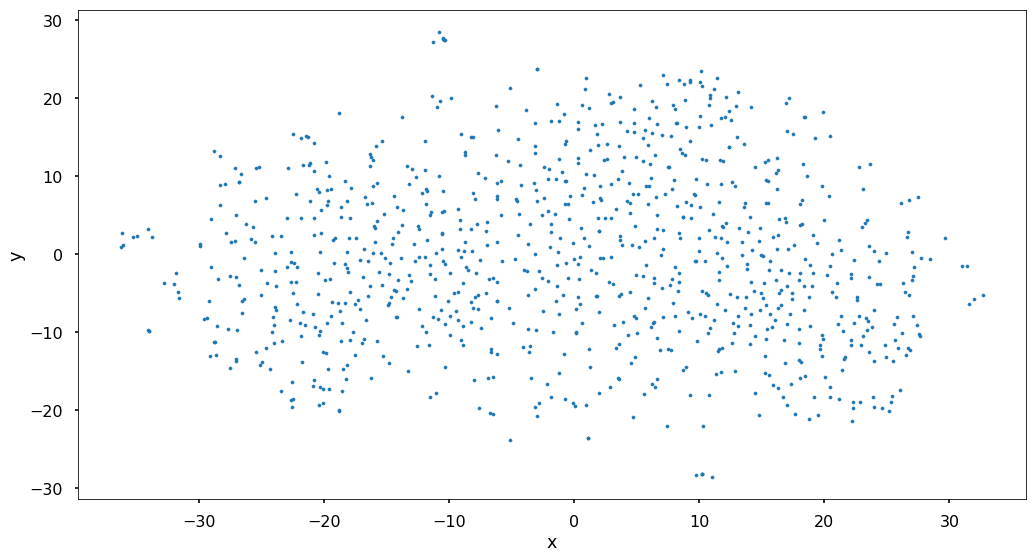

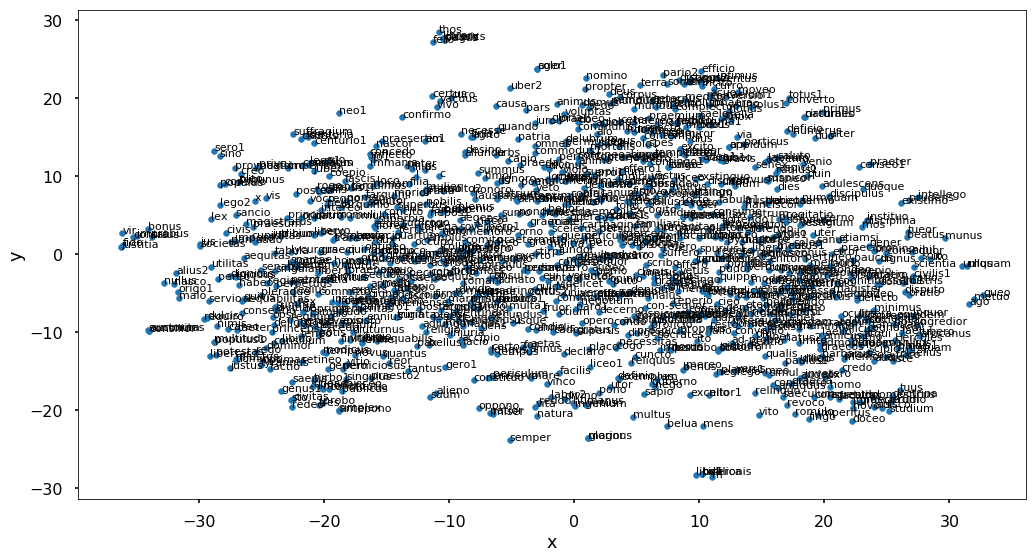

In [36]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from utils import plot_points

dim_reducer = TSNE(n_components=2, random_state=0)
#dim_reducer = PCA(n_components=2)

all_word_vectors_matrix = drp2vec.wv.syn0
all_word_vectors_matrix_2d = dim_reducer.fit_transform(all_word_vectors_matrix)

points = plot_points(all_word_vectors_matrix_2d, drp2vec.wv.vocab)

We will investigate by looking at the clusterings of certain words.

/Users/marccanby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


94700
Bounds: (21.556303024291992, 31.556303024291992) (-17.947964668273926, -7.947964668273926)


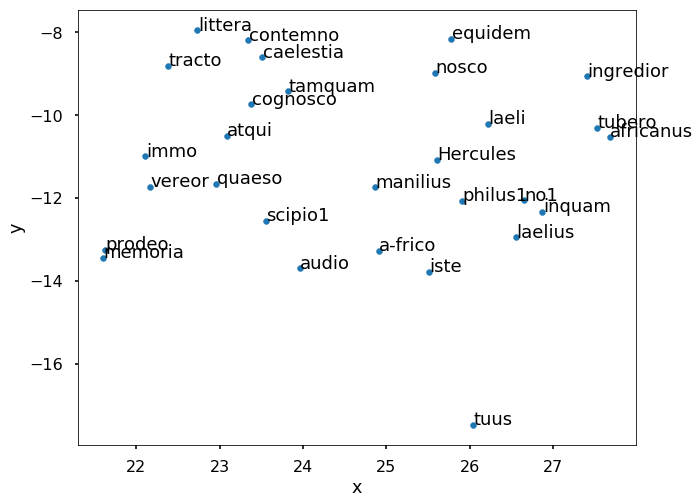

Bounds: (-34.90102958679199, -24.901029586791992) (-4.016015708446503, 5.983984291553497)


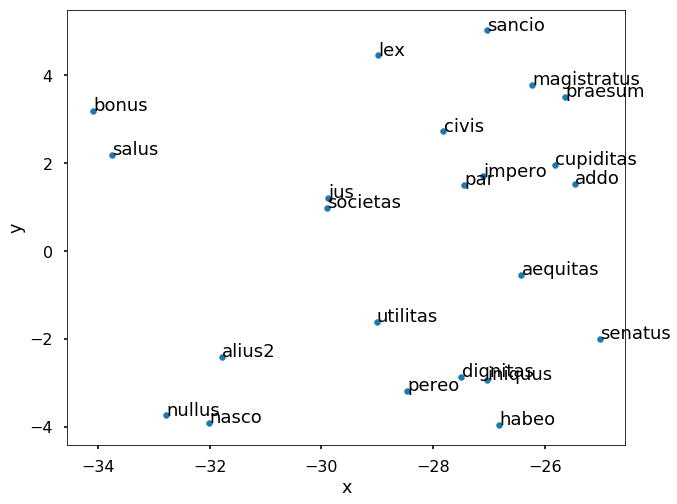

Bounds: (18.56563949584961, 28.56563949584961) (-8.007321834564209, 1.992678165435791)


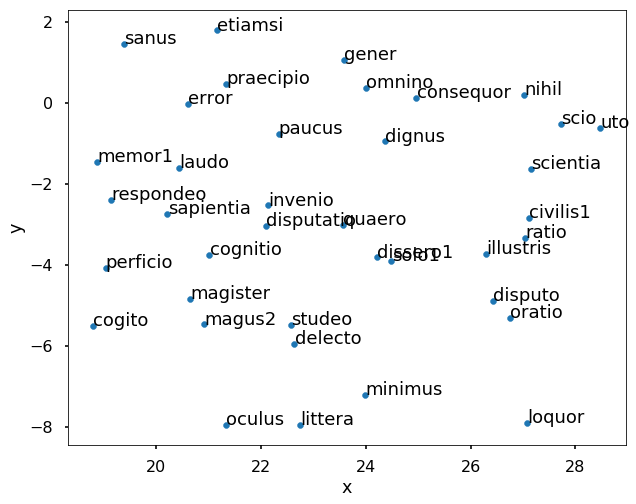

Bounds: (-27.10984230041504, -17.10984230041504) (-11.403462886810303, -1.4034628868103027)


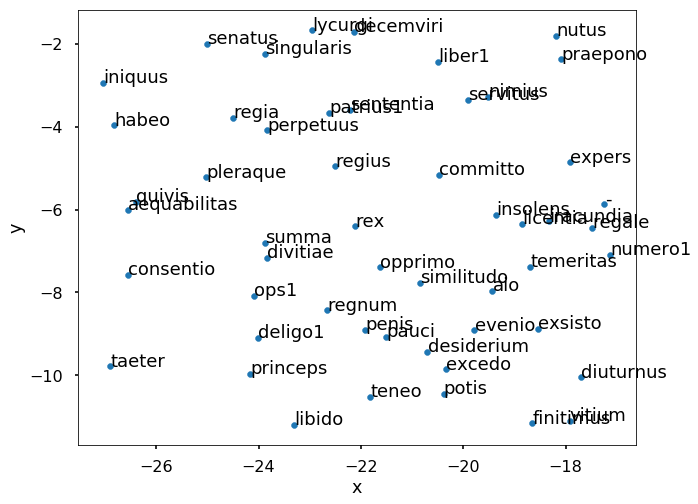

Bounds: (-29.9346981048584, -19.9346981048584) (-18.855220794677734, -8.855220794677734)


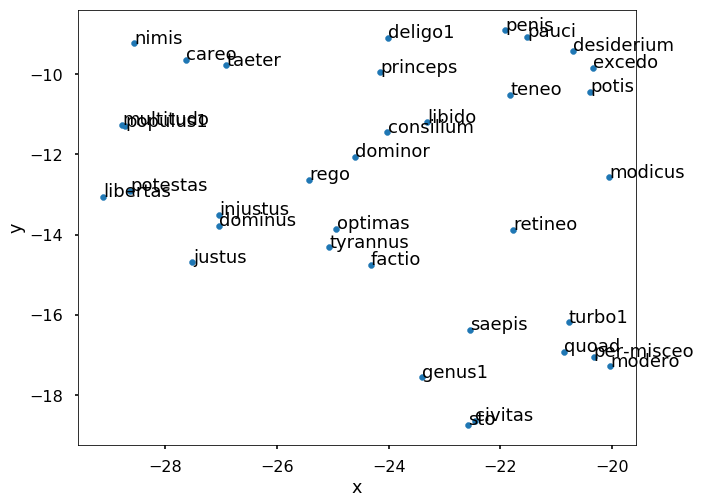

In [60]:
from utils import plot_area_of_word
print(drp2vec.wv.syn0.size)
plot_area_of_word("laelius", points)
plot_area_of_word("societas", points)
plot_area_of_word("quaero", points)
plot_area_of_word("rex", points)
plot_area_of_word("optimas", points)

## Part III. Sentence Clustering: K-Means

Now we work on clustering sentences based on meaning. We first encode each sentence into a TFIDF encoding:

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer = lambda x: x.split('\t'))
X_train = tfidf_vectorizer.fit_transform(list(map(lambda x: '\t'.join(x), tokenized_sents)))
terms = tfidf_vectorizer.get_feature_names()

Next we do k-means clustering.

In [31]:
from sklearn.cluster import KMeans
import pandas as pd

num_clusters = 4
km_model = KMeans(n_clusters=num_clusters)
km_model.fit(X_train)
clusters = km_model.labels_.tolist()

frame = {'cluster': clusters}
frame = pd.DataFrame(frame, index = [clusters] , columns = ['cluster'])

print("Number of sentences per cluster:")
frame['cluster'].value_counts()

Number of sentences per cluster:


0    515
2    150
1     65
3     43
Name: cluster, dtype: int64

Now we print the key words indicative of each cluster.

In [34]:
order_centroids = km_model.cluster_centers_.argsort()[:, ::-1] 
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    to_print = ""
    for ind in order_centroids[i, :15]: #replace 6 with n words per cluster
    	to_print+= " " + (terms[ind])
    print(to_print) #add whitespace

Cluster 0 words: homo magnus verus eo1 civitas fero ito bonus facio multus primus vir moveo causa res
Cluster 1 words: scipio1 inquam reor probo quaero magnus censeo1 sentio rex verus libet num laeli ito ceter
Cluster 2 words: publicus res populus1 redeo bonus rego sto genus1 civitas eo1 nullus cicero potestas reor habeo
Cluster 3 words: laelius inquam verus minimus philus1 nosco no1 saepis prope sentio scipio1 $ magus2 laeliu vilicus


Now we reduce the dimensionality of the distance vectors using TSNE or PCA so we can visualize the clusters.

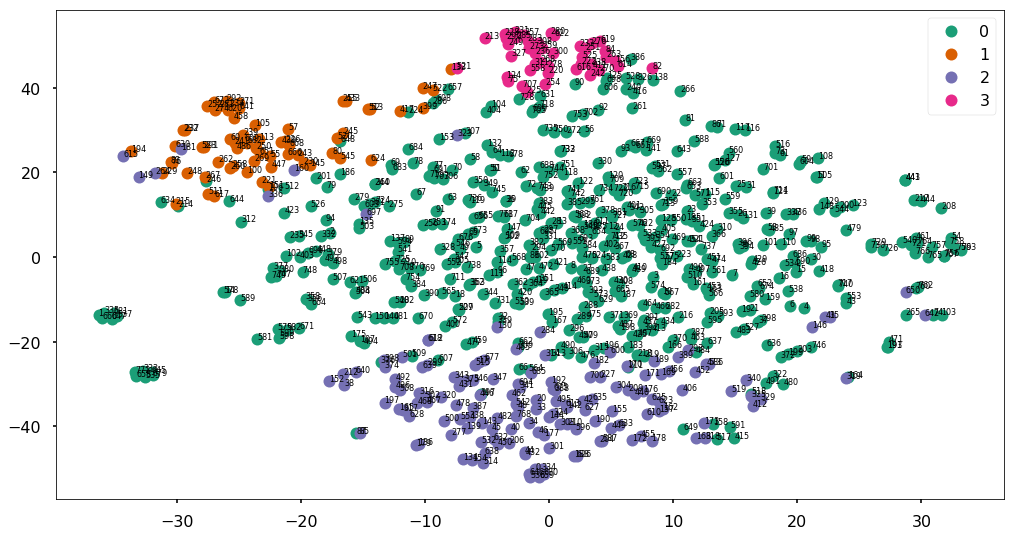

In [41]:
from sklearn.metrics.pairwise import cosine_similarity
from utils import plot_clusters

dist = 1 - cosine_similarity(X_train) # distances between sentences

#dim_reducer2 = manifold.TSNE(n_components=2, dissimilarity="precomputed",random_state=0)
#dim_reducer2 = PCA(n_components=2)
dim_reducer2 = TSNE(n_components = 2)
pos = dim_reducer2.fit_transform(dist)  # shape (n_components, n_samples)
plot_clusters(pos, clusters)

Now we print sentences representative from each cluster.

In [51]:
from utils import sample_by_cluster

for i in range((num_clusters)):
    print("Cluster " + str(i) + " sentences:")
    sample_by_cluster(i, 3, clusters, original_sentences, nonempty_idxes)
    print("\n")

Cluster 0 sentences:
tum philus: 'none mihi videtur' inquit 'quod hi venerunt alius nobis sermo esse quaerendus, sed agendum accuratius et dicendum dignum aliquid horum auribus.'
(scipio) 'ergo, ut vilicus naturam agri novit, dispensator litteras scit, uterque autem se a scientiae delectatione ad efficiendi utilitatem refert, sic noster hic rector studuerit sane iuri et legibus cognoscendis, fontis quidem earum utique perspexerit, sed se responsitando et lectitando et scriptitando ne impediat, ut quasi dispensare rem publicam et in ea quodam modo vilicare possit, is summi iuris peritissimus, sine quo iustus esse nemo potest, civilis non inperitus, sed ita ut astrorum gubernator, physicorum medicus; uterque enim illis ad artem suam utitur, sed se a suo munere non impedit.
quocirca permirum mihi videri solet, quae sit tanta doc'


Cluster 1 sentences:
tum ille (scipio): 'istum ipsum' (laelius) 'e est tibi ex eis ipsis qui adsunt bella copia, velut a te ipso ordiare.'
't ille (scipio) 'qu